Eploratory Data Analysis

Data contains the following attributes which can be used as a potential feature for the model

- ID
- Call Duration
- Call Frequency
- Financial Loss
- Flagged by Carrier
- Is International
- Previous Contact Count
- Country Prefix
- Call Type
- Timestamp
- Device Battery

The last column, scam call is the target variable

The steps that are taken in the Exploratory Data Analysis prcoess are as follows:

- Data Inspection
- Data Validation
- Data Analysis

In [1]:
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt

Data Inspection

In [2]:
# query the database using sqlalchemy
engine = create_engine('sqlite:///data/calls.db')
df = pd.read_sql_query("SELECT * FROM calls", engine)
df

,ID,Call Duration,Call Frequency,Financial Loss,Flagged by Carrier,Is International,Previous Contact Count,Country Prefix,Call Type,Timestamp,Device Battery,Scam Call
0,947429,-719,12,42.130000,Suspicious,Yes,1,95,Voip,2023-07-23 09:04:00,Fully Charged,Scam
1,540498,116,3,29.900000,Unlikely,Yes,0,91,Mobile,2023-09-05 20:11:00,Fully Charged,Scam
2,434243,29,16,723.460000,Very Suspicious,Yes,2,91,Voip,2023-12-16 11:03:00,Charging,Scam
3,903537,-563,4,64.287478,Unlikely,Yes,3,91,Telegram,2023-02-25 10:41:00,Fully Charged,Not Scam
4,969179,312,19,0.000000,Unlikely,Yes,0,91,Telegram,2023-11-10 15:53:00,Fully Charged,Scam
...,...,...,...,...,...,...,...,...,...,...,...,...
11995,496033,116,15,NaN,Unlikely,Yes,4,7,Voip,2023-05-03 14:32:00,Fully Charged,Not Scam
11996,730960,621,3,11.740000,Suspicious,Yes,0,MM,Landline,2023-08-04 00:16:00,Fully Charged,Scam
11997,806410,-27,4,102.450000,Suspicious,Yes,0,MM,Voip,2024-03-22 01:31:00,Not Charging,Scam
11998,481032,-127,9,NaN,Unlikely,Yes,0,1,Landline,2023-07-11 17:04:00,Charging,Not Scam


From the inspection of the data, Timestamp would be a feature that need to be transformed because the algorithm cannot read the DateTime object. Moreover, there seems to be some negative values for features that should not contain negative values. These will be addressed in data validation.

In the code below, a check is done on specific columns that should be unique and are categorical in nature to prevent double counting certain entries

In [3]:
columns_to_check = ["Flagged by Carrier","Is International","Country Prefix","Call Type"]
for col in columns_to_check:
  unique_values = df[col].unique()
  print(f"Unique values in column '{col}': {unique_values}")
  
df['Call Type'] = df['Call Type'].replace('Whats App', 'WhatsApp')


Unique values in column 'Flagged by Carrier': ['Suspicious' 'Unlikely' 'Very Suspicious']
Unique values in column 'Is International': ['Yes' 'No']
Unique values in column 'Country Prefix': ['95' '91' '44' '65' 'MM' '1' '7']
Unique values in column 'Call Type': ['Voip' 'Mobile' 'Telegram' 'Whats App' 'Landline' 'WhatsApp']


Here, it can be seen that for Call Type, there is a repeated entry for whatsapp due to different naming conventions. This is modified so that the evaluation of the data is accurate.

Data Validation

In [4]:
# returns the columns as well as the entries for each of the columns
df.info()

# returns the number of entries that are null for each of the columns
df.isnull().sum()

# check data for the Financial Loss column
df['Financial Loss']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      12000 non-null  int64  
 1   Call Duration           12000 non-null  int64  
 2   Call Frequency          12000 non-null  int64  
 3   Financial Loss          10597 non-null  float64
 4   Flagged by Carrier      12000 non-null  object 
 5   Is International        12000 non-null  object 
 6   Previous Contact Count  12000 non-null  int64  
 7   Country Prefix          12000 non-null  object 
 8   Call Type               12000 non-null  object 
 9   Timestamp               12000 non-null  object 
 10  Device Battery          12000 non-null  object 
 11  Scam Call               12000 non-null  object 
dtypes: float64(1), int64(4), object(7)
memory usage: 1.1+ MB


0         42.130000
1         29.900000
2        723.460000
3         64.287478
4          0.000000
            ...    
11995           NaN
11996     11.740000
11997    102.450000
11998           NaN
11999      0.000000
Name: Financial Loss, Length: 12000, dtype: float64

From the info method, it can be seen that there are multiple columns with the object data type, which will also need to be converted to a more suitable data type for the model to read.

Moreover, from the info and isnull methods in the data frame, it can be seen that every feature has 12000 entries except for Financial Loss, which has only 10597 entries. From the insepction of the data, it can be seen that 1403 of these entries are null in the database. These entries will either have to be removed or interpolated from other data points to ensure that the null entries do not affect the performance of the model.

Upon futhur inspection, even though there are reports of financial lost being 0, the null data value for this column can also be interprated as a 0, since null data points would mean the same thing as no financial loss reported.

In [5]:
# converts all null values in the 'Financial Loss' column to 0
df['Financial Loss'].fillna(0, inplace=True)

In [6]:
# returns how many unique values are in each of these columns
df.nunique()

ID                        10000
Call Duration               986
Call Frequency               26
Financial Loss             5004
Flagged by Carrier            3
Is International              2
Previous Contact Count        9
Country Prefix                7
Call Type                     5
Timestamp                  9916
Device Battery                3
Scam Call                     2
dtype: int64

The nunique method that is called here is more applicable for the ID column, since it is supposed to represent a unique identifier for each call. By this definition, since the total number of data entries with a value in the ID column is 12000, but there are only 10000 unique values for ID, this means that there are 2000 data entries that are repeated. The duplicated entries should be removed so that they do not affect the analysis of the data.

In [7]:
# the following code checks for how many instances of a id is found in the data frame, and appends the index of that entry to non_unique_id if the total number of instances is more than 1
# this pandas Index object is then used to filter out the non-unique values in the initial data frame, adding it to non_unique_df
non_unique_ids = df['ID'].value_counts()[df['ID'].value_counts() > 1].index
non_unique_df = df[df['ID'].isin(non_unique_ids)]
non_unique_df

,ID,Call Duration,Call Frequency,Financial Loss,Flagged by Carrier,Is International,Previous Contact Count,Country Prefix,Call Type,Timestamp,Device Battery,Scam Call
3,903537,-563,4,64.287478,Unlikely,Yes,3,91,Telegram,2023-02-25 10:41:00,Fully Charged,Not Scam
14,679236,-299,3,-76.400609,Unlikely,Yes,3,95,Mobile,2023-03-20 08:53:00,Charging,Not Scam
29,170089,-42,4,0.000000,Unlikely,Yes,2,44,Voip,2023-05-17 20:18:00,Charging,Not Scam
31,433615,-272,17,0.000000,Unlikely,Yes,0,95,Landline,2023-10-24 12:31:00,Fully Charged,Not Scam
33,482199,-113,20,24.604398,Unlikely,No,0,65,Landline,2023-09-15 01:11:00,Not Charging,Not Scam
...,...,...,...,...,...,...,...,...,...,...,...,...
11995,496033,116,15,0.000000,Unlikely,Yes,4,7,Voip,2023-05-03 14:32:00,Fully Charged,Not Scam
11996,730960,621,3,11.740000,Suspicious,Yes,0,MM,Landline,2023-08-04 00:16:00,Fully Charged,Scam
11997,806410,-27,4,102.450000,Suspicious,Yes,0,MM,Voip,2024-03-22 01:31:00,Not Charging,Scam
11998,481032,-127,9,0.000000,Unlikely,Yes,0,1,Landline,2023-07-11 17:04:00,Charging,Not Scam


In [8]:
# as a sanity check, a random specific ID that is know to have non-unique values is checked to see if the data provided for this unique ID is the same,
# which turns out to be true, so these data entries can be eliminated safely without the fear of losing out on potential data entries. 
specific_id = 903537
specific_id_df = df[df['ID'] == specific_id]
specific_id_df

,ID,Call Duration,Call Frequency,Financial Loss,Flagged by Carrier,Is International,Previous Contact Count,Country Prefix,Call Type,Timestamp,Device Battery,Scam Call
3,903537,-563,4,64.287478,Unlikely,Yes,3,91,Telegram,2023-02-25 10:41:00,Fully Charged,Not Scam
10481,903537,-563,4,64.287478,Unlikely,Yes,3,91,Telegram,2023-02-25 10:41:00,Fully Charged,Not Scam
10981,903537,-563,4,64.287478,Unlikely,Yes,3,91,Telegram,2023-02-25 10:41:00,Fully Charged,Not Scam
11481,903537,-563,4,64.287478,Unlikely,Yes,3,91,Telegram,2023-02-25 10:41:00,Fully Charged,Not Scam
11981,903537,-563,4,64.287478,Unlikely,Yes,3,91,Telegram,2023-02-25 10:41:00,Fully Charged,Not Scam


In [9]:
# remove all duplicates in non_unique df except for exactly one instance of each of these non_unique entries to preserve the data without double counting.
# this concatenates all unique IDs in the original dataframe with non_unique_df and saves it to the original dataframe, effectively removing duplicated data within the dataframe.
non_unique_df = non_unique_df.drop_duplicates(subset='ID', keep='first')
df = pd.concat([df[~df['ID'].isin(non_unique_ids)], non_unique_df])
df

,ID,Call Duration,Call Frequency,Financial Loss,Flagged by Carrier,Is International,Previous Contact Count,Country Prefix,Call Type,Timestamp,Device Battery,Scam Call
0,947429,-719,12,42.130000,Suspicious,Yes,1,95,Voip,2023-07-23 09:04:00,Fully Charged,Scam
1,540498,116,3,29.900000,Unlikely,Yes,0,91,Mobile,2023-09-05 20:11:00,Fully Charged,Scam
2,434243,29,16,723.460000,Very Suspicious,Yes,2,91,Voip,2023-12-16 11:03:00,Charging,Scam
4,969179,312,19,0.000000,Unlikely,Yes,0,91,Telegram,2023-11-10 15:53:00,Fully Charged,Scam
5,546947,-120,20,0.000000,Unlikely,Yes,1,44,Mobile,2023-12-29 06:20:00,Fully Charged,Not Scam
...,...,...,...,...,...,...,...,...,...,...,...,...
9783,119356,129,22,688.040000,Suspicious,Yes,0,MM,Landline,2023-03-13 11:54:00,Fully Charged,Scam
9896,663713,-30,14,0.000000,Unlikely,Yes,0,MM,Telegram,2023-01-26 06:43:00,Charging,Scam
9909,171449,29,20,89.414311,Unlikely,Yes,5,7,Mobile,2023-08-11 15:03:00,Charging,Not Scam
9920,441679,533,20,0.000000,Unlikely,Yes,0,91,Telegram,2023-02-16 03:43:00,Charging,Scam


With this, all non unique IDs are removed from the original data frame to prevent double counting of any data entries that could skew the model. Moreover, it should be noted that ID is not a valid feature because it is just a unique identifier used to identify which call is being referred to.

In [10]:
# returns the statistics of the columns that are numerical in value
df.describe()

,ID,Call Duration,Call Frequency,Financial Loss,Previous Contact Count
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,549171.604600,112.394100,10.653800,87.317890,1.855000
std,258983.069885,284.370395,5.841212,185.619696,1.769545
min,100017.000000,-787.000000,2.000000,-896.400000,0.000000
25%,328241.750000,9.000000,6.000000,0.000000,0.000000
50%,542268.500000,47.000000,9.000000,0.000000,1.000000
75%,777904.500000,288.000000,15.000000,76.474018,3.000000
max,999709.000000,822.000000,27.000000,1055.440000,8.000000


Based on the statistics returned for the columns that are of the integer or float data type, it can be seen that it is likely that normalization might need to be done due to the large difference in the magnitude of the mean for some features, like Previous Contact Count and Call Duration. Moreover, the minimum values for Financial Loss and Call Duration show that the entries contain negative numbers.

In [11]:
print("The number of rows with a number less than 0 in the Financial Loss column is", len(df[df['Financial Loss'] < 0]))
print("The number of rows with a number less than 0 in the Call Duration column is", len(df[df['Call Duration'] < 0]))

The number of rows with a number less than 0 in the Financial Loss column is 232
The number of rows with a number less than 0 in the Call Duration column is 2500


From the describe method, it can be seen that the Call Duration and Finanical Loss columns have some invalid data, because Call Duration and Financial Loss cannot be negative by definition. The removal of these entries should be dependent on how important these features are to the outcome of whether or not the call is a scam, because the other features of this data entry could be important and the number of entries that have to be eliminated are a large proportion of the data set, ~2.4% for financial loss and ~27.9% for call duration (although these entries may overlap). The first few cells in data analysis aim to show whether or not there is a relationship between Call Duration / Financial Loss and whether or not the call is a scam, by visulising the data using a scatterplot, box plot and histogram.

In [12]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month
df['Day'] = df['Timestamp'].dt.day
df['Hour'] = df['Timestamp'].dt.hour

The code above transforms the Timestamp column to 4 new columns, Year, Month, Day, Hour, so that the data can be better analysed below.

Data Analysis

Exploring the relationship between Financial Loss and Scam Call  

c:\Users\65911\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\65911\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\65911\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\65911\AppData\Local\Programs\Python\Python311

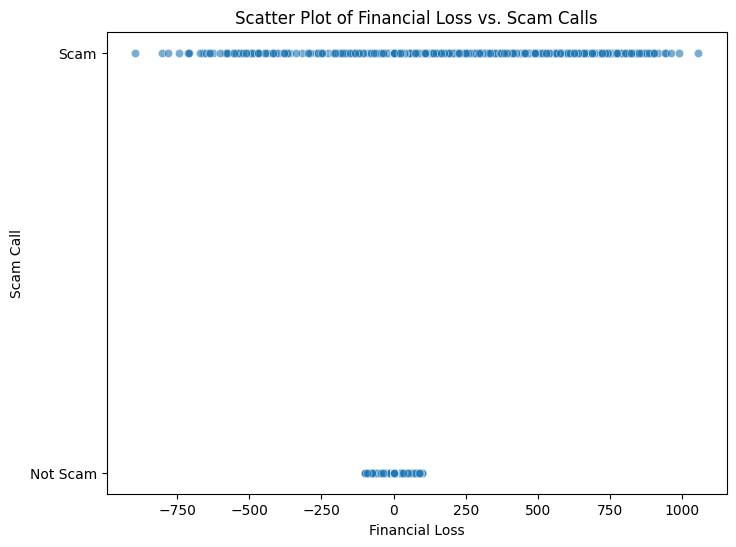

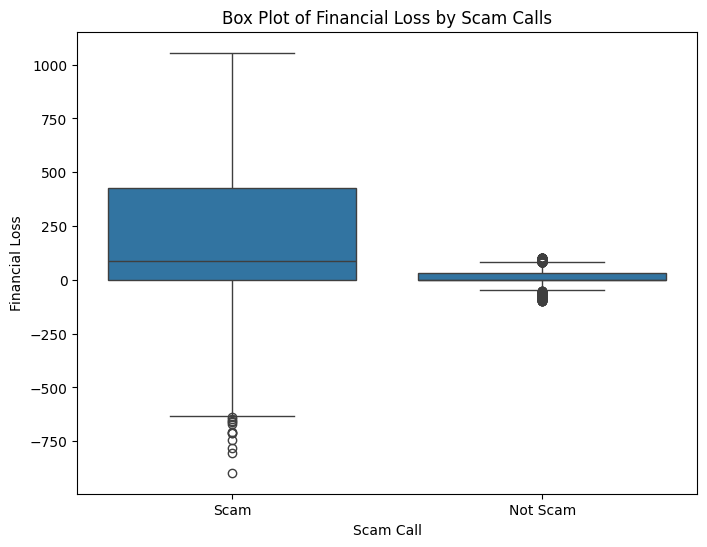

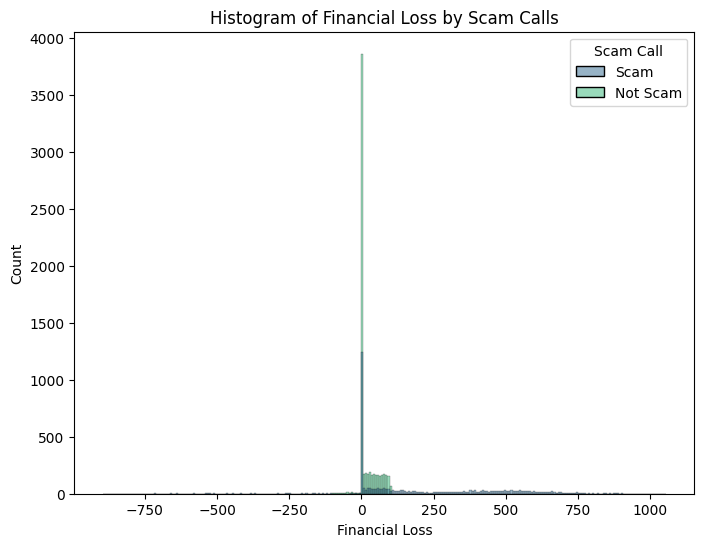

In [13]:
# Scatterplot between Financial Loss and Scam Call
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Financial Loss', y='Scam Call', alpha=0.6)
plt.title('Scatter Plot of Financial Loss vs. Scam Calls')
plt.xlabel('Financial Loss')
plt.ylabel('Scam Call')

# Box Plot between Financial Loss and Scam Call
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Scam Call', y='Financial Loss')
plt.title('Box Plot of Financial Loss by Scam Calls')
plt.xlabel('Scam Call')
plt.ylabel('Financial Loss')

# Histogram between Financial Loss and Scam Call
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Financial Loss', hue='Scam Call', palette='viridis')
plt.title('Histogram of Financial Loss by Scam Calls')
plt.xlabel('Financial Loss')
plt.ylabel('Count')

plt.show()


- Scatter Plot

    The scatter plot shows some correlation between a low financial loss and the call turning out to not be a scam. However, it must be noted that there are still a large portion of the calls that have a financial loss close to 0 but still end up being a scam call. Thus, the scatter plot results are not a very good indicator of whether or not this feature has a correlation with a scam call.

- Box Plot

    The box plot shows a very similar result to the scatter plot, where there is some correlation between a low financial loss and the call turning out to not be a scam, but there is still a fair amount of calls that are close to 0 that end up becoming a scam. Thus, the box plot results are also not a very good indicator of whether or not this feature has a correlation with whether or not the call is a scam.


- Histogram

    The histogram shows an exteremely similar distribution of the data points between entries that are both scam and not scam calls, which can be seen by a relatively similar proportion of both scam and non-scam calls at financial losses close to 0. However, it should be noted that towards higher amounts of financial loss, the likelyhood of the call being a scam is much higher as well. Thus, the correlation between financial loss and whether or not the call is a scam seems contentious.

In conclusion, the data is inconclusive on whether or not Financial Loss has correlation with scam calls.

Exploring the relationship between Call Duration and Scam Call  

c:\Users\65911\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\65911\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\65911\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\65911\AppData\Local\Programs\Python\Python311

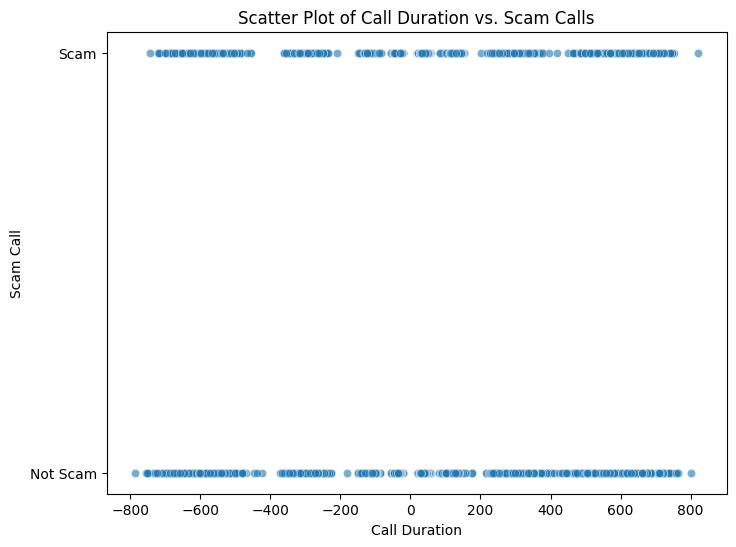

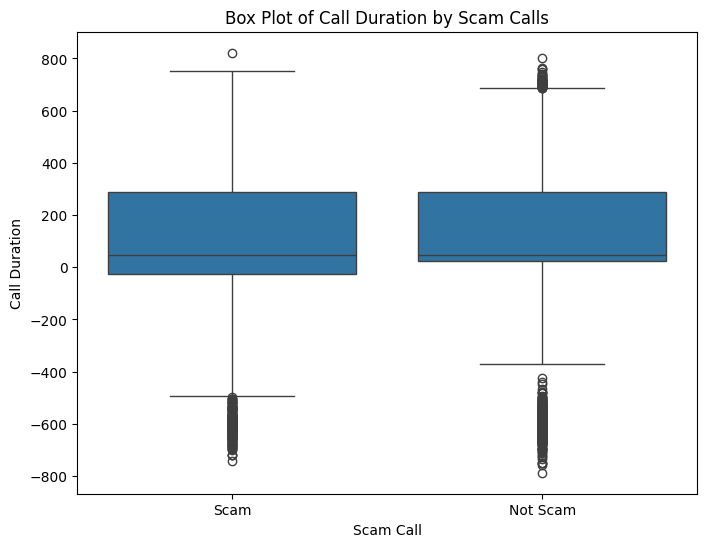

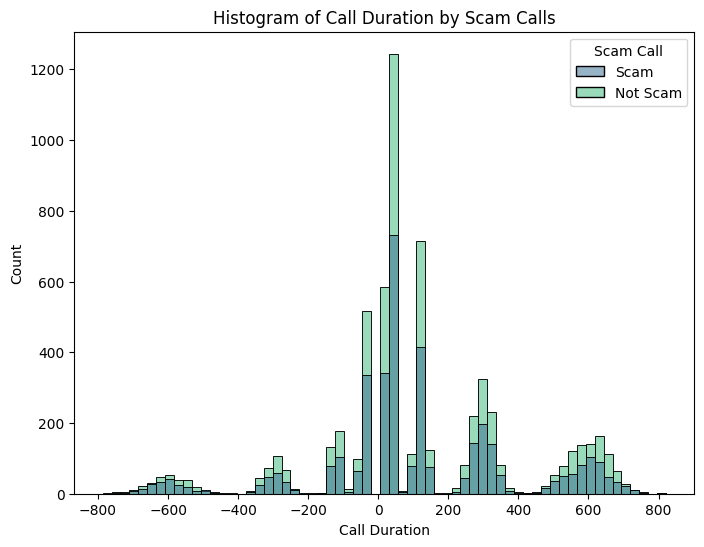

In [14]:
# Scatterplot between Call Duration and Scam Call
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Call Duration', y='Scam Call', alpha=0.6)
plt.title('Scatter Plot of Call Duration vs. Scam Calls')
plt.xlabel('Call Duration')
plt.ylabel('Scam Call')

# Box Plot between Call Duration and Scam Call
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Scam Call', y='Call Duration')
plt.title('Box Plot of Call Duration by Scam Calls')
plt.xlabel('Scam Call')
plt.ylabel('Call Duration')

# Histogram between Call Duration and Scam Call
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Call Duration', hue='Scam Call', palette='viridis')
plt.title('Histogram of Call Duration by Scam Calls')
plt.xlabel('Call Duration')
plt.ylabel('Count')

plt.show()


- Scatter Plot

    The scatter plot for call duration against scam calls show that the result of the call being a scam is quite spread out between all durations of the call, and shows that there might not be a good correlation between the duration of a call and whether or not the call is actually a scam. Thus, the scatter plot seems to lean towards call duration not having a correlation with whether or not the call turns out to be a scam.

- Box Plot

    The box plot shows almost no variation between the call duration and whether or not the call is a scam, implying that the distribution is similar. Thus, the data seems to deduce that there is not a good correlation between call duration and a scam call.

- Histogram

    The histogram shows an extermely similar distribution of the data points between entries that are both scam and not scam calls, which can be seen by a relatively similar proportion of both scam and non-scam calls at every call duration. Thus, the histogram leans towards dropping call duration as a feature since it will not be used in the model and hence will not affect the overall performance.

In conclusion, the data shows low correlation with whether or not the call turns out to actually be a scam.

Exploring the relationship between Call Frequency and Scam Call

c:\Users\65911\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\65911\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\65911\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\65911\AppData\Local\Programs\Python\Python311

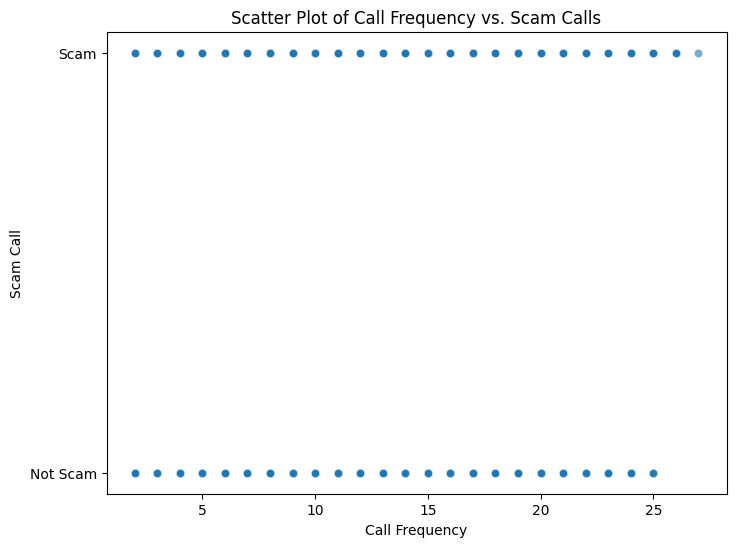

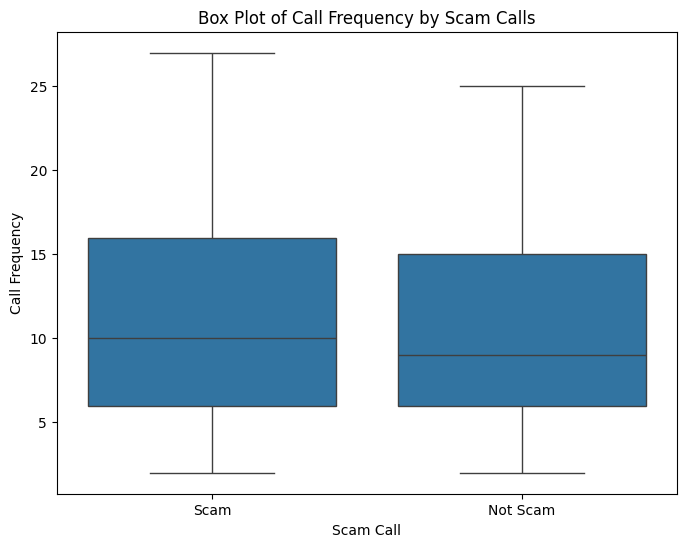

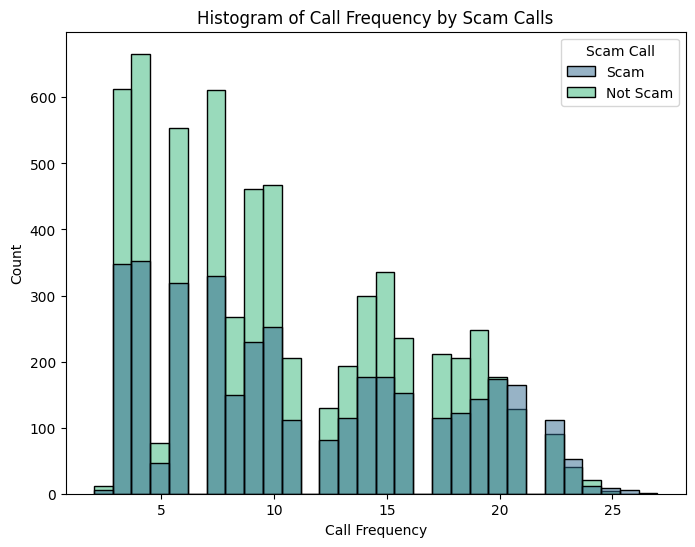

In [15]:
# Scatterplot between Call Frequency and Scam Call
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Call Frequency', y='Scam Call', alpha=0.6)
plt.title('Scatter Plot of Call Frequency vs. Scam Calls')
plt.xlabel('Call Frequency')
plt.ylabel('Scam Call')

# Box Plot between Call Frequency and Scam Call
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Scam Call', y='Call Frequency')
plt.title('Box Plot of Call Frequency by Scam Calls')
plt.xlabel('Scam Call')
plt.ylabel('Call Frequency')

# Histogram between Call Frequency and Scam Call
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Call Frequency', hue='Scam Call', palette='viridis')
plt.title('Histogram of Call Frequency by Scam Calls')
plt.xlabel('Call Frequency')
plt.ylabel('Count')

plt.show()

- Scatter Plot

    The scatter plot for call frequency against scam calls show that the result of the call being a scam is extremely spread out between all frequencies of calls, and shows that there might not be a good correlation between the frequency of a call and whether or not the call is actually a scam. Thus, the scatter plot seems to lean towards call frequency not having a correlation with scam calls.

- Box Plot

    The box plot shows almost no variation between the call frequency and whether or not the call is a scam, implying that the distribution is similar, although it must be conceded that the max call frequency for scam calls is noticeably higher than the call frequency for non-scam calls. Thus, the model seems to deduce that there is not a good correlation between call frequency and a scam call.

- Histogram

    The histogram shows an extermely similar distribution of the data points between entries that are both scam and not scam calls for frequencies below 20, which can be seen by a relatively similar proportion of both scam and non-scam calls at every call frequency. However, it should be noted that towards the higher call frequencies, the rate at which the calls are actually a scam start to get higher. Thus, the histogram seems to be inconclusive on whether or not there is a correlation between call frequency and whether or not the call is a scam.

In conclusion, the data need to be furthur validated using the machine learning pipeline.

Exploring the relationship between Flagged by Carrier and Scam Call

c:\Users\65911\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\65911\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\65911\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

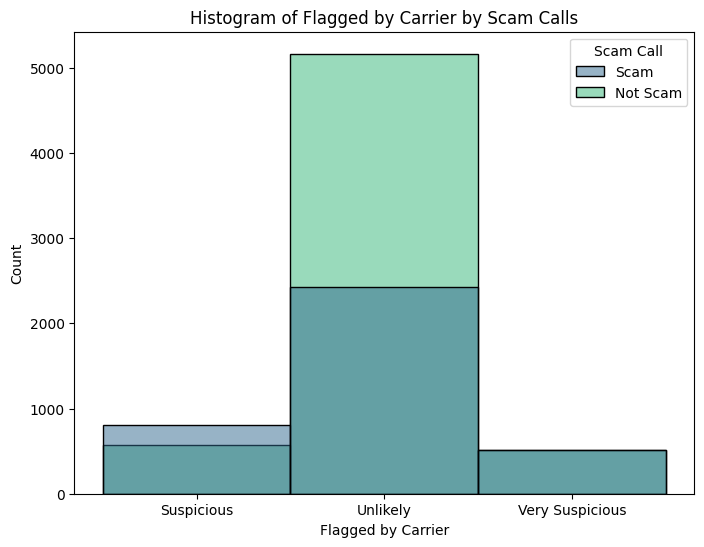

In [16]:
# Histogram between Flagged by Carrier and Scam Call
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Flagged by Carrier', hue='Scam Call', palette='viridis')
plt.title('Histogram of Flagged by Carrier by Scam Calls')
plt.xlabel('Flagged by Carrier')
plt.ylabel('Count')

plt.show()

In the case of flagged by carrier and scam call, the relationship of the data is more straight forward because they are binary/trinary in nature, so the correlation between the two can be seen purely based on the frequency of scam or not scam calls based on each option. 

- Histogram

    The histogram shows that there is a correlation between flagged by carrier and whether or not the call turns out to be a scam, since a large proportion of the total calls in the suspicious and very suspicious categories are scam calls while the larger proportion of total calls in the unlikely category are not scam calls. Thus, there seems to be a correlation between flagged by carrier and whether or not the call is actually a scam call.

In conclusion, the data supports keeping flagged by carrier as a feature for the model becasue it shows correlation with whether or not the call turns out to actually be a scam.

Exploring the relationship between Is International and Scam Call

c:\Users\65911\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\65911\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\65911\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

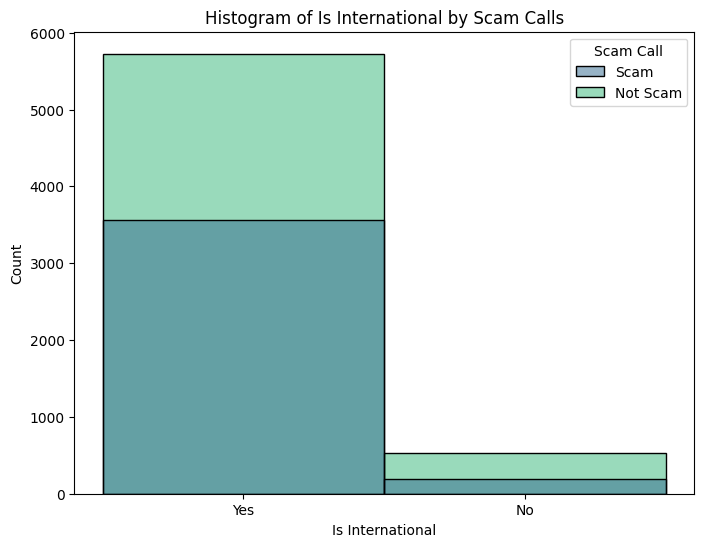

In [17]:
# Histogram between Is International and Scam Call
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Is International', hue='Scam Call', palette='viridis')
plt.title('Histogram of Is International by Scam Calls')
plt.xlabel('Is International')
plt.ylabel('Count')

plt.show()

In the case of is international and scam call, the relationship of the data is more straight forward because they are both binary in nature, so the correlation between the two can be seen purely based on the frequency of scam or not scam calls based on whether or not the call is international. 

- Histogram

    The histogram shows a relatively similar distribution of the data points between entries that are both scam and not scam calls. Thus, the data seems to show that is international does not have a correlation with scam calls.

In conclusion, the data supports dropping is international as a feature for the model becasue it shows low correlation with whether or not the call turns out to actually be a scam.

Exploring the relationship between Previous Contact Count and Scam Call

c:\Users\65911\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\65911\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\65911\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\65911\AppData\Local\Programs\Python\Python311

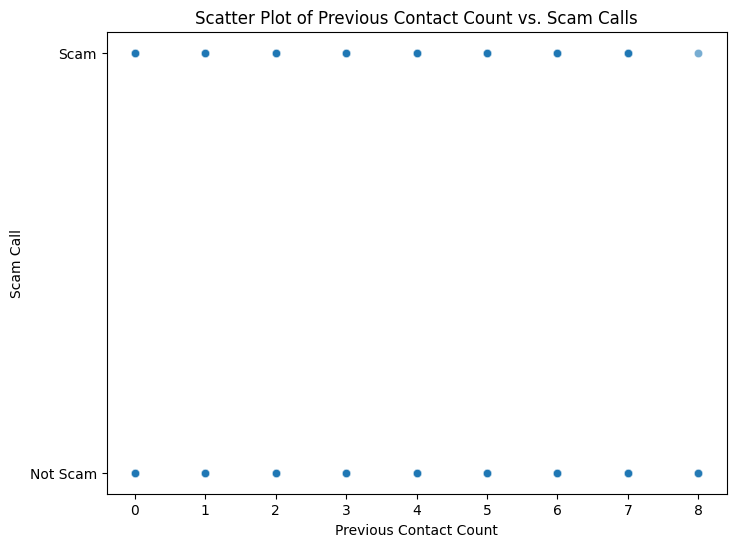

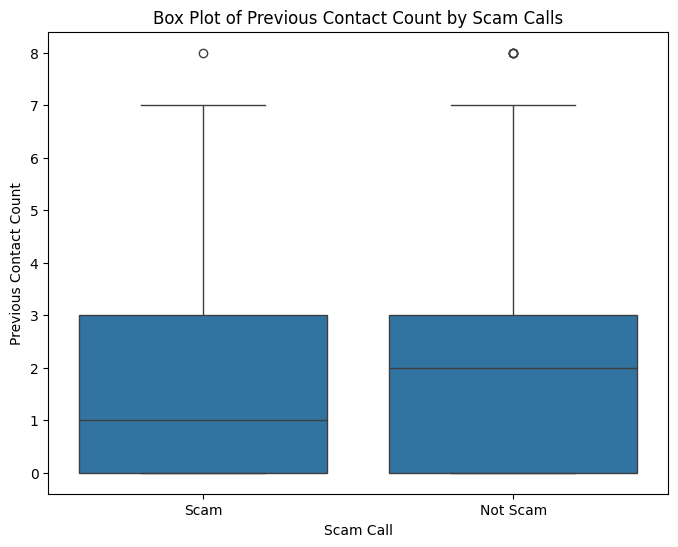

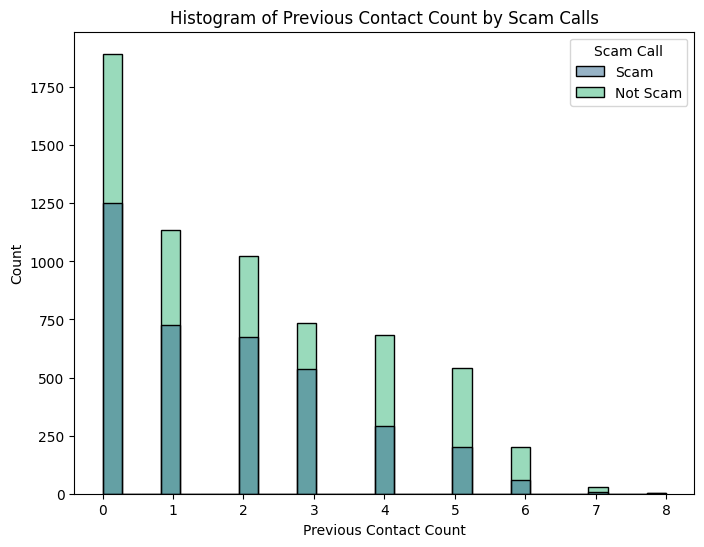

In [18]:
# Scatterplot between Previous Contact Count and Scam Call
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Previous Contact Count', y='Scam Call', alpha=0.6)
plt.title('Scatter Plot of Previous Contact Count vs. Scam Calls')
plt.xlabel('Previous Contact Count')
plt.ylabel('Scam Call')

# Box Plot between Previous Contact Count and Scam Call
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Scam Call', y='Previous Contact Count')
plt.title('Box Plot of Previous Contact Count by Scam Calls')
plt.xlabel('Scam Call')
plt.ylabel('Previous Contact Count')

# Histogram between Previous Contact Count and Scam Call
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Previous Contact Count', hue='Scam Call', palette='viridis')
plt.title('Histogram of Previous Contact Count by Scam Calls')
plt.xlabel('Previous Contact Count')
plt.ylabel('Count')

plt.show()

- Scatter Plot

    The scatter plot for previous contact count against scam calls show that the result of the call being a scam is extremely spread out between all previous contact counts, and shows that there is not a good correlation between the previous contact count and whether or not the call is actually a scam. Thus, the scatter plot seems to lean towards previous contact count not having a correlation with scam calls.

- Box Plot

    The box plot shows almost no variation between the previous contact count and whether or not the call is a scam, implying that the distribution is similar. Thus, it can be deduced that there is not a good correlation between previous contact count and a scam call, and thus, the box plot seems to lean towards previous contact count not having a correlation with scam calls.

- Histogram

    The histogram shows an extermely similar distribution of the data points between entries that are both scam and not scam calls, which can be seen by an extremely similar proportion of both scam and non-scam calls at every previous contact count frequency. Thus, the histogram leans towards dropping previous contact count as a feature since it does not make the model more accurate.

In conclusion, the data supports dropping previous contact count as a feature for the model becasue it shows low correlation with whether or not the call turns out to actually be a scam.

Relationship between Country Prefix and Scam Call

c:\Users\65911\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\65911\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\65911\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

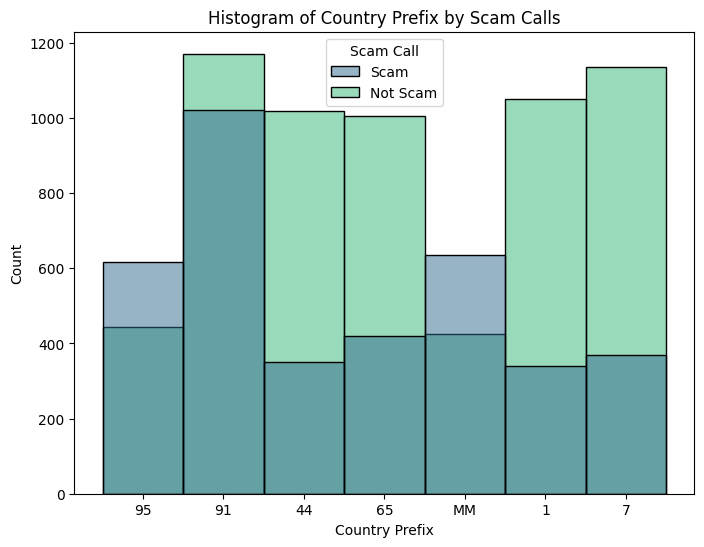

In [19]:
# Histogram between Country Prefix and Scam Call
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Country Prefix', hue='Scam Call', palette='viridis')
plt.title('Histogram of Country Prefix by Scam Calls')
plt.xlabel('Country Prefix')
plt.ylabel('Count')

plt.show()

In the case of country prefix and scam call, the relationship of the data is more straight forward because they are both categorical in nature, so the correlation between the two can be seen purely based on the frequency of scam or not scam calls based on whether or not the call is international. 

- Histogram

    The histogram shows a large increase for the proportion of scam calls for certain country prefixes like 95, 91 and MM, which indicates that there could be a correlation between country prefix and whether or not the call turns out to be a scam. 

In conclusion, the data supports keeping country prefix as a feature for the model becasue it shows correlation with whether or not the call turns out to actually be a scam.

Relationship between Call Type and Scam Call

c:\Users\65911\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\65911\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\65911\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

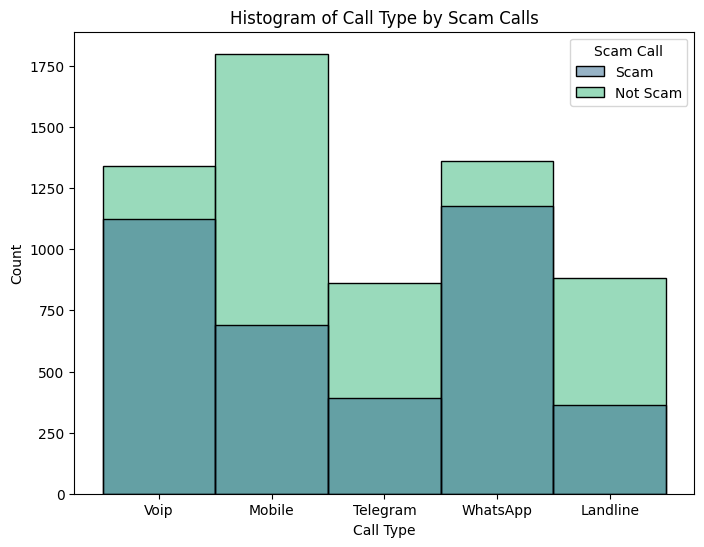

In [20]:
# Histogram between Call Type and Scam Call
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Call Type', hue='Scam Call', palette='viridis')
plt.title('Histogram of Call Type by Scam Calls')
plt.xlabel('Call Type')
plt.ylabel('Count')

plt.show()

In the case of call type and scam call, the relationship of the data is more straight forward because they are both categorical in nature, so the correlation between the two can be seen purely based on the frequency of scam or not scam calls based on what the call type is. 

- Histogram

    The histogram shows a large increase for the proportion of scam calls for certain call types like Voip and Whatsapp, which indicates that there could be a correlation between call type and whether or not the call turns out to be a scam.

In conclusion, the data supports keeping call type as a feature for the model becasue it shows correlation with whether or not the call turns out to actually be a scam.

Relationship between Year and Scam Call

c:\Users\65911\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\65911\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\65911\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

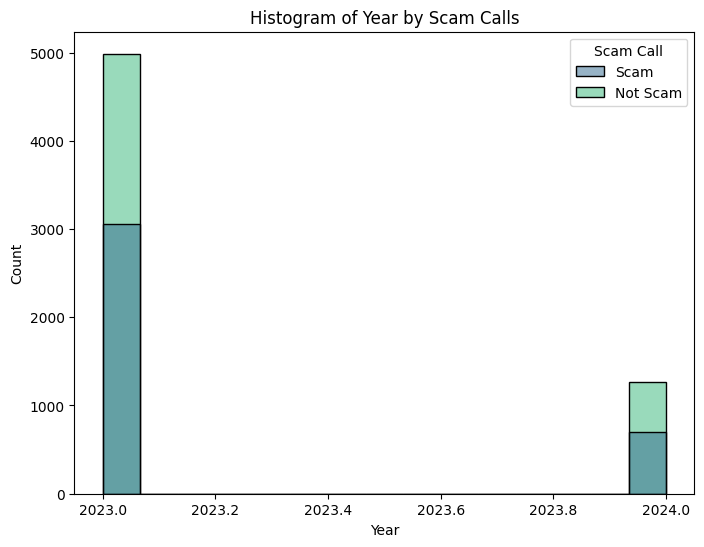

In [21]:
# Histogram between Year and Scam Call
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Year', hue='Scam Call', palette='viridis')
plt.title('Histogram of Year by Scam Calls')
plt.xlabel('Year')
plt.ylabel('Count')

plt.show()

In the case of year and scam call, the relationship of the data is more straight forward because they are both categorical in nature (since there are no partial years), so the correlation between the two can be seen purely based on the frequency of scam or not scam calls based on what the year is. 

- Histogram

    The histogram shows a similar proportion between scam calls and non-scam calls between the years, which suggest that there may not be a very clear correlation between the two.

In conclusion, the data supports dropping year as a feature for the model becasue it shows correlation with whether or not the call turns out to actually be a scam.

Relationship between Month and Scam Call

c:\Users\65911\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\65911\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\65911\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

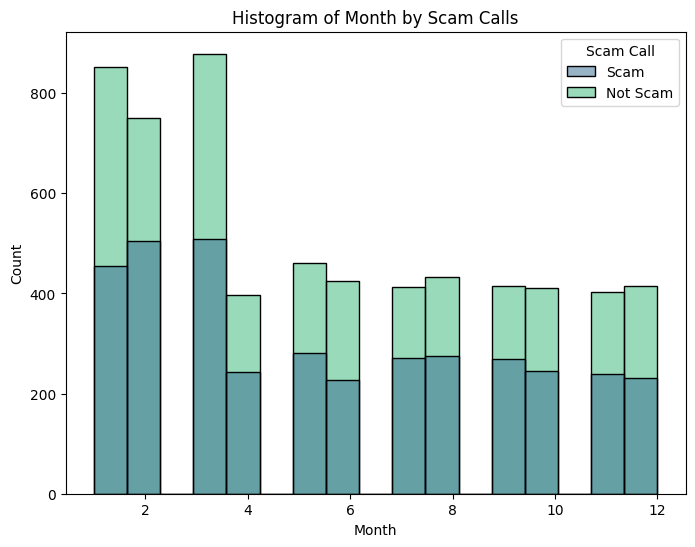

In [22]:
# Histogram between Month and Scam Call
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Month', hue='Scam Call', palette='viridis')
plt.title('Histogram of Month by Scam Calls')
plt.xlabel('Month')
plt.ylabel('Count')

plt.show()

In the case of month and scam call, the relationship of the data is more straight forward because they are both categorical in nature(since there are no partial months), so the correlation between the two can be seen purely based on the frequency of scam or not scam calls based on what the month is. 

- Histogram

    The histogram show a similar distribution across the months, which show that there is no correlation between the two.

In conclusion, the data supports dropping month as a feature for the model becasue it shows no correlation between whether or not the call turns out to actually be a scam.

Relationship between Day and Scam Call

c:\Users\65911\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\65911\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\65911\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

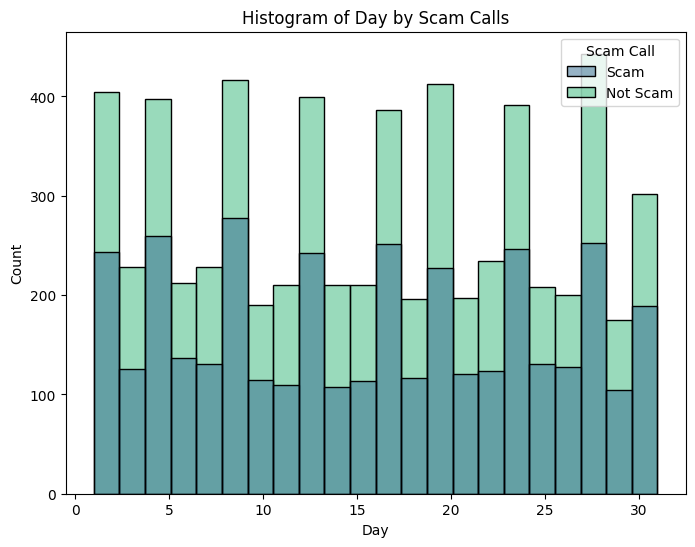

In [23]:
# Histogram between Day and Scam Call
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Day', hue='Scam Call', palette='viridis')
plt.title('Histogram of Day by Scam Calls')
plt.xlabel('Day')
plt.ylabel('Count')

plt.show()

In the case of day and scam call, the relationship of the data is more straight forward because they are both categorical in nature(since there are no partial days), so the correlation between the two can be seen purely based on the frequency of scam or not scam calls based on what the day is. 

- Histogram

    The histogram show a similar distribution across the days, which show that there is no correlation between the two.

In conclusion, the data supports dropping day as a feature for the model becasue it shows no correlation between whether or not the call turns out to actually be a scam.

Relationship between Hour and Scam Call

c:\Users\65911\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\65911\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\65911\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

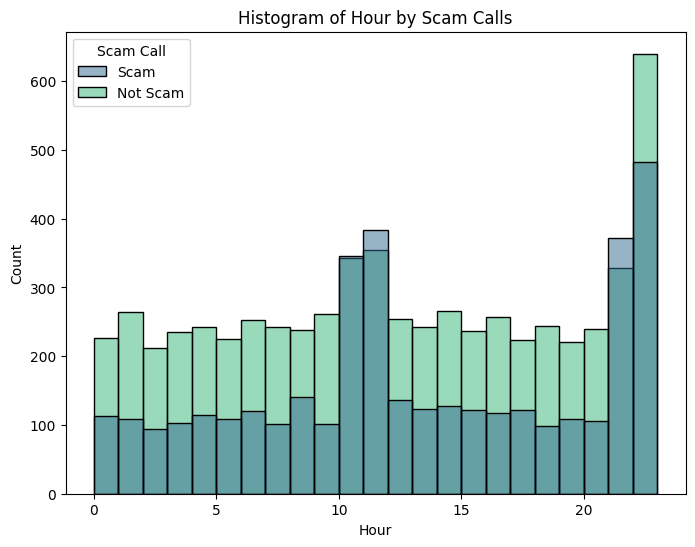

In [24]:
# Histogram between Hour and Scam Call
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Hour', hue='Scam Call', palette='viridis')
plt.title('Histogram of Hour by Scam Calls')
plt.xlabel('Hour')
plt.ylabel('Count')

plt.show()

In the case of hour and scam call, the relationship of the data is more straight forward because they are both categorical in nature(since we do not take minutes into account), so the correlation between the two can be seen purely based on the frequency of scam or not scam calls based on what the hour is. 

- Histogram

    The histogram show a spike in scam calls during certain hours, which indicate that there is a good correlation between the hour that the call is made as well as whether or not the call is actually a scam.

In conclusion, the data supports keeping hour as a feature for the model becasue it shows a good correlation between whether or not the call turns out to actually be a scam.

Relationship between Month and Scam Call

c:\Users\65911\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\65911\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\65911\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

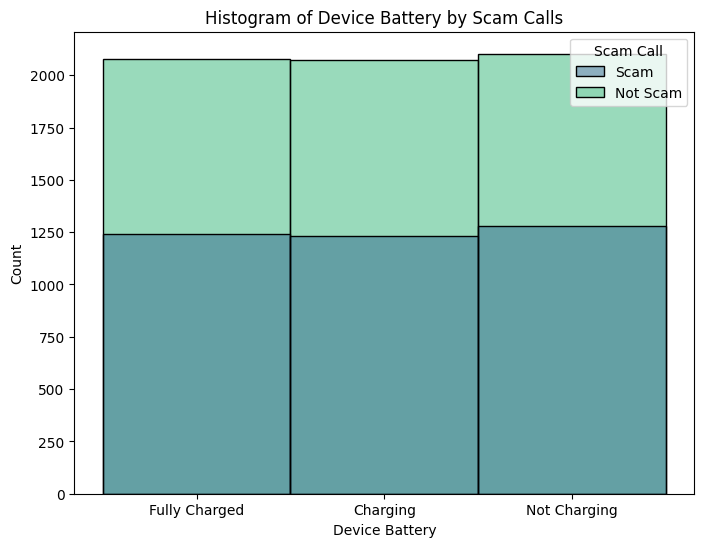

In [25]:
# Histogram between Device Battery and Scam Call
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Device Battery', hue='Scam Call', palette='viridis')
plt.title('Histogram of Device Battery by Scam Calls')
plt.xlabel('Device Battery')
plt.ylabel('Count')

plt.show()

In the case of device battery and scam call, the relationship of the data is more straight forward because they are both categorical in nature, so the correlation between the two can be seen purely based on the frequency of scam or not scam calls based on what the device battery is. 

- Histogram

    The histogram show a very similar distribution across the device battery, which show that there is no correlation between the two.

In conclusion, the data supports dropping device battery as a feature for the model becasue it shows no correlation between whether or not the call turns out to actually be a scam.